# Ischemic heart disease in Men vs Women
At what age is ischemic heart disease first discovered for men vs women.
Below we have used a synthetic dataset of patient data with 28491 women and 28116 men.

In [6]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""

df = pd.read_sql(query, conn)

## The actual distributions
Below the distributions of the ages, where the disease is discovered for men and women, is graphed.

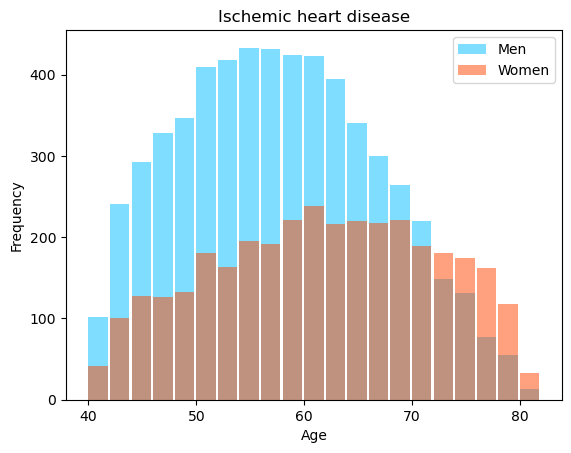

In [11]:
import matplotlib.pyplot as plt
df2 = df.copy()
df2["age"] = df2["age"].apply(lambda a: a - (a % 2)) #group even ages
wdf = df2.where(df2.gender == "F").dropna().groupby(['age', 'gender']).count().reset_index()
mdf = df2.where(df2.gender == "M").dropna().groupby(['age', 'gender']).count().reset_index()
x = wdf["age"]
y = wdf["patient"]
xmen = mdf["age"]
ymen = mdf["patient"]

plt.bar(xmen, ymen, width=1.8, align='edge', label='Men', alpha=0.5, color='deepskyblue')
plt.bar(x, y, width=1.8, align='edge', label='Women', alpha=0.5, color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ischemic heart disease')
plt.legend()
plt.show()

Mens distribution peaks earlier than the womens and there seem to be more cases for men. Around age 55 for men and 62 for women. These are properties we would like to persist after differential privacy is applied.